## Install Dependencies

In [1]:
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

In [2]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn ipympl

Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [3]:
# %matplotlib widget

In [4]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import math
import zipfile
import wfdb as wf
import os
import pickle
import sys
import datetime
import cv2
import random
import random as python_random
import scipy.interpolate as interp
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
from pathlib import Path
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from scipy.fft import fft, ifft, fftfreq, rfft,irfft, rfftfreq
from sklearn import preprocessing

In [5]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

In [6]:
np.random.seed(seed_value)
vec = np.random.randint(1, 10)
print(vec)
random.seed(42)
print(random.random())
tf.random.set_seed(42)
print(tf.random.uniform([1])) 

7
0.6394267984578837
Metal device set to: Apple M1
tf.Tensor([0.6645621], shape=(1,), dtype=float32)


2023-02-15 11:47:56.860116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-15 11:47:56.860607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Extracting Data

In [7]:
module = os.path.abspath('./WESAD/')
if module not in sys.path:
    sys.path.append(module)
from DataManager import DataManager

## Data Preprocessing

In [8]:
# config
debug = False;

In [9]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [10]:
test_subject = 2
rest_subjects = [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
fs = 700.0
lowcut = 0.01
highcut = 3.0

In [11]:
def getBand(signal, highcut, lowcut, order, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    s3 = lfilter(b, a, signal)
    return s3

def cutBandHelper(signal, highcut, lowcut, order, fs):
    new_signal = signal.copy()
    nyq = 0.5 * fs
    lowcut = lowcut/nyq
    highcut = highcut/nyq
    b, a = butter(order, lowcut, btype = 'low')
    d, c = butter(order, highcut, btype = 'high')
    s1 = lfilter(b, a, signal)
    s2 = lfilter(d, c, new_signal)
    return s1, s2

In [12]:
def loadData(subject_id):
    data = DataManager()
    all_subject_data = np.array([]);
    all_subject_labels = np.array([]);

    ## Subject Data Extraction
    if(debug): 
        print("Processing subject id: ", subject_id);
    subject = data.load(subject_id)

    if(debug):
        print('baseline: ', subject[0], '\nstress: ', subject[1], '\namusement: ', subject[2], '\nbase_label: ', subject[3], '\nstress_label: ', subject[4], '\namuse_label: ', subject[5])

    ecg_base = subject[0]
    ecg_stress = subject[1]
    ecg_amusement = subject[2]

    ecg_base_T = ecg_base.T
    ecg_stress_T = ecg_stress.T
    ecg_amusement_T = ecg_amusement.T

    ecg_base_data = ecg_base_T[0]
    ecg_stress_data = ecg_stress_T[0]
    ecg_amusement_data = ecg_amusement_T[0]
    

    if(debug): 
        print('ecg_base_data:', ecg_base_data)
        print('ecg_stress_data:', ecg_stress_data)
        print('ecg_amusement_data:', ecg_amusement_data)

    print('base size:', ecg_base_data.size)
    print('stress size:', ecg_stress_data.size)
    print('amusement size:', ecg_amusement_data.size)
    
    ecg_base_data = ecg_base_data[0:798000]
    ecg_stress_data = ecg_stress_data[0:430500]
    ecg_amusement_data = ecg_amusement_data[0:253400]

    print('new base:', ecg_base_data.size)
    print('new stress:', ecg_stress_data.size)
    print('new amuse:', ecg_amusement_data.size)

    return ecg_base_data, ecg_stress_data, ecg_amusement_data


## Test Data

In [13]:
test_all_subject_data = np.array([]);
test_base, test_stress, test_amusement = loadData(test_subject)

test_base_filtered = getBand(test_base, highcut, lowcut, 1, fs)
test_stress_filtered = getBand(test_stress, highcut, lowcut, 1, fs)
test_amusement_filtered = getBand(test_amusement, highcut, lowcut, 1, fs)

base_secs = len(test_base) // 700 # Number of seconds in signal X
base_samps = int(base_secs * 256 )    # Number of samples to downsample
test_base_down = signal.resample(test_base, base_samps)
    
stress_secs = len(test_stress) // 700 # Number of seconds in signal X
stress_samps = int(stress_secs * 256 )    # Number of samples to downsample
test_stress_down = signal.resample(test_stress, stress_samps)

amuse_secs = len(test_amusement) // 700 # Number of seconds in signal X
amuse_samps = int(amuse_secs * 256 )    # Number of samples to downsample
test_amuse_down = signal.resample(test_amusement, amuse_samps)
  
window_size = 256
window_shift = 256

test_heart_beat_base = []
for i in range(0,len(test_base_down) - window_size,window_shift):
    test_heart_beat_base.append(test_base_down[i:window_size + i])
test_heart_beat_base.pop()
#     heart_beat_base = np.array(list(heart_beat_base[:]), dtype=float)

test_heart_beat_stress = []
for i in range(0,len(test_stress_down) - window_size,window_shift):
    test_heart_beat_stress.append(test_stress_down[i:window_size + i])
test_heart_beat_stress.pop()
#     heart_beat_stress = np.array(list(heart_beat_stress[:]), dtype=float)

test_heart_beat_amuse = []
for i in range(0,len(test_amuse_down) - window_size,window_shift):
    test_heart_beat_amuse.append(test_amuse_down[i:window_size + i])
test_heart_beat_amuse.pop()
#     heart_beat_amuse = np.array(list(heart_beat_amuse[:]), dtype=float)

for idx, idxval in enumerate(test_heart_beat_base):
    test_heart_beat_base[idx] = (test_heart_beat_base[idx] - test_heart_beat_base[idx].min()) / test_heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
    test_heart_beat_base[idx] = np.append(test_heart_beat_base[idx], 0.0) #Baseline = 0

for idx, idxval in enumerate(test_heart_beat_stress):
    test_heart_beat_stress[idx] = (test_heart_beat_stress[idx] - test_heart_beat_stress[idx].min()) / test_heart_beat_stress[idx].ptp() # Normalize the readings to a 0-1 range 
    test_heart_beat_stress[idx] = np.append(test_heart_beat_stress[idx], 1.0) #Stress = 1    

for idx, idxval in enumerate(test_heart_beat_amuse):
    test_heart_beat_amuse[idx] = (test_heart_beat_amuse[idx] - test_heart_beat_amuse[idx].min()) / test_heart_beat_amuse[idx].ptp() # Normalize the readings to a 0-1 range 
    test_heart_beat_amuse[idx] = np.append(test_heart_beat_amuse[idx], 2.0) #Amusement = 2
    
test_heart_beat_all = np.concatenate((test_heart_beat_base, test_heart_beat_stress, test_heart_beat_amuse), axis=0)
test_subject_data = np.array(list(test_heart_beat_all[:]), dtype=float)


if(test_all_subject_data.size == 0):
    test_all_subject_data = test_subject_data
else:
    if(test_subject_data.size != 0):
        test_all_subject_data = np.concatenate((test_all_subject_data, test_subject_data), axis=0)

print("New data shape", test_subject_data.shape, "Total Shape: ", test_all_subject_data.shape)
        
#SMOTE to balance the data
test_df_final_data_X = pd.DataFrame(data=test_all_subject_data[:, :-1])
test_df_final_data_Y = pd.DataFrame(data=test_all_subject_data[:,-1])

test_smote = SMOTE(sampling_strategy='not majority')
test_data, test_labels = test_smote.fit_resample(test_df_final_data_X, test_df_final_data_Y)

Loading data for S2
base size: 800800
stress size: 430500
amusement size: 253400
new base: 798000
new stress: 430500
new amuse: 253400
New data shape (2111, 257) Total Shape:  (2111, 257)


In [14]:
test_labels.value_counts()

0.0    1138
1.0    1138
2.0    1138
dtype: int64

In [15]:
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Dimension:", test_labels.ndim)

Test data shape: (3414, 256)
Test labels shape: (3414, 1)
Dimension: 2


In [16]:
test_labels = pd.DataFrame(test_labels).to_numpy()
y_test = test_labels.reshape(-1)

In [17]:
print("Test labels shape:", y_test.shape)
print("Dimension:", y_test.ndim)

Test labels shape: (3414,)
Dimension: 1


In [18]:
#Reshape test data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_test = np.array(test_data).reshape(test_data.shape[0], test_data.shape[1], 1)

In [19]:
print('size of X_test:', X_test.shape)
print('size of y_test:', y_test.shape)

print('Test:', Counter(y_test))

size of X_test: (3414, 256, 1)
size of y_test: (3414,)
Test: Counter({0.0: 1138, 1.0: 1138, 2.0: 1138})


## Training Data

In [20]:
all_subject_data = np.array([]);

for idx, idxval in enumerate(rest_subjects):
    ecg_base_data, ecg_stress_data, ecg_amusement_data = loadData(idxval)
    
    base_s1, base_s2 = cutBandHelper(ecg_base_data, highcut, lowcut, 1, fs)
    stress_s1, stress_s2 = cutBandHelper(ecg_stress_data, highcut, lowcut, 1, fs)
    amusement_s1, amusement_s2 = cutBandHelper(ecg_amusement_data, highcut, lowcut, 1, fs)
    
    new_base = np.sum([base_s1, test_base_filtered, base_s2], axis=0)
    new_stress = np.sum([stress_s1, test_stress_filtered, stress_s2], axis=0)
    new_amusement = np.sum([amusement_s1, test_amusement_filtered, amusement_s2], axis=0)
    
    print('reformed base size:', new_base.size)
    print('reformed stress size:', new_stress.size)
    print('reformed amuse size:', new_amusement.size)
    
    base_secs = len(new_base) // 700 # Number of seconds in signal X
    base_samps = int(base_secs * 256 )    # Number of samples to downsample
    base_down = signal.resample(new_base, base_samps)
    
    stress_secs = len(new_stress) // 700 # Number of seconds in signal X
    stress_samps = int(stress_secs * 256 )    # Number of samples to downsample
    stress_down = signal.resample(new_stress, stress_samps)
    
    amuse_secs = len(new_amusement) // 700 # Number of seconds in signal X
    amuse_samps = int(amuse_secs * 256 )    # Number of samples to downsample
    amuse_down = signal.resample(new_amusement, amuse_samps)
    
    window_size = 256
    window_shift = 256

    heart_beat_base = []
    for i in range(0,len(base_down) - window_size,window_shift):
        heart_beat_base.append(base_down[i:window_size + i])
    heart_beat_base.pop()
#     heart_beat_base = np.array(list(heart_beat_base[:]), dtype=float)

    heart_beat_stress = []
    for i in range(0,len(stress_down) - window_size,window_shift):
        heart_beat_stress.append(stress_down[i:window_size + i])
    heart_beat_stress.pop()
#     heart_beat_stress = np.array(list(heart_beat_stress[:]), dtype=float)

    heart_beat_amuse = []
    for i in range(0,len(amuse_down) - window_size,window_shift):
        heart_beat_amuse.append(amuse_down[i:window_size + i])
    heart_beat_amuse.pop()
#     heart_beat_amuse = np.array(list(heart_beat_amuse[:]), dtype=float)
    
    for idx, idxval in enumerate(heart_beat_base):
        heart_beat_base[idx] = (heart_beat_base[idx] - heart_beat_base[idx].min()) / heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
        heart_beat_base[idx] = np.append(heart_beat_base[idx], 0.0) #Baseline = 0

    for idx, idxval in enumerate(heart_beat_stress):
        heart_beat_stress[idx] = (heart_beat_stress[idx] - heart_beat_stress[idx].min()) / heart_beat_stress[idx].ptp() # Normalize the readings to a 0-1 range 
        heart_beat_stress[idx] = np.append(heart_beat_stress[idx], 1.0) #Stress = 1    

    for idx, idxval in enumerate(heart_beat_amuse):
        heart_beat_amuse[idx] = (heart_beat_amuse[idx] - heart_beat_amuse[idx].min()) / heart_beat_amuse[idx].ptp() # Normalize the readings to a 0-1 range 
        heart_beat_amuse[idx] = np.append(heart_beat_amuse[idx], 2.0) #Amusement = 2
        
    heart_beat_all = np.concatenate((heart_beat_base, heart_beat_stress, heart_beat_amuse), axis=0)
    subject_data = np.array(list(heart_beat_all[:]), dtype=float)
    
    if(all_subject_data.size == 0):
        all_subject_data = subject_data
    else:
        if(subject_data.size != 0):
            all_subject_data = np.concatenate((all_subject_data, subject_data), axis=0)

    print("New data shape", subject_data.shape, "Total Shape: ", all_subject_data.shape)
    
#SMOTE to balance the data
df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

smote = SMOTE(sampling_strategy='not majority')
train_data, train_labels = smote.fit_resample(df_final_data_X, df_final_data_Y)

Loading data for S3
base size: 798000
stress size: 448000
amusement size: 262500
new base: 798000
new stress: 430500
new amuse: 253400
reformed base size: 798000
reformed stress size: 430500
reformed amuse size: 253400
New data shape (2111, 257) Total Shape:  (2111, 257)
Loading data for S4
base size: 810601
stress size: 444500
amusement size: 260400
new base: 798000
new stress: 430500
new amuse: 253400
reformed base size: 798000
reformed stress size: 430500
reformed amuse size: 253400
New data shape (2111, 257) Total Shape:  (4222, 257)
Loading data for S5
base size: 838600
stress size: 451500
amusement size: 261800
new base: 798000
new stress: 430500
new amuse: 253400
reformed base size: 798000
reformed stress size: 430500
reformed amuse size: 253400
New data shape (2111, 257) Total Shape:  (6333, 257)
Loading data for S6
base size: 826000
stress size: 455000
amusement size: 260400
new base: 798000
new stress: 430500
new amuse: 253400
reformed base size: 798000
reformed stress size: 

In [21]:
train_labels.value_counts()

0.0    15932
1.0    15932
2.0    15932
dtype: int64

In [22]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train data shape: (47796, 256)
Train labels shape: (47796, 1)
Dimension: 2


In [23]:
train_labels = pd.DataFrame(train_labels).to_numpy()
train_labels = train_labels.reshape(-1)

In [24]:
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train labels shape: (47796,)
Dimension: 1


## Train and Validation data split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.3, random_state=42)

In [26]:
#Reshape train and validation data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

In [27]:
print('size of X_train:', X_train.shape)
print('size of X_val:', X_val.shape)

print('size of y_train:', y_train.shape)
print('size of y_val:', y_val.shape)

print('Train:', Counter(y_train), '\nVal:', Counter(y_val))

size of X_train: (33457, 256, 1)
size of X_val: (14339, 256, 1)
size of y_train: (33457,)
size of y_val: (14339,)
Train: Counter({0.0: 11184, 2.0: 11179, 1.0: 11094}) 
Val: Counter({1.0: 4838, 2.0: 4753, 0.0: 4748})


## 1D CNN Model Architecture

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [29]:
reset_random_seeds()
# kernel_regularizer =tf.keras.regularizers.l2(l=0.004)
# initializer = tf.keras.initializers.HeUniform()
cnn_model = tf.keras.models.Sequential()
cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', input_shape= (X_train.shape[1],1)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=15, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(Dense(units = 3, activation='softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 5)            30        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 10)           260       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 64, 10)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 15)            765       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 32, 15)           0

In [30]:
epochs=50
batch_size = 32

In [31]:
def step_decay(epoch):
  initial_lrate = 0.005
  drop = 0.6
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [32]:
opt = tf.keras.optimizers.SGD( learning_rate=0.0, momentum=0.6, nesterov=False)

cnn_model.compile(optimizer= opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = cnn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=2)

Epoch 1/50


2023-02-15 11:48:23.320093: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-15 11:48:23.599587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-15 11:48:36.915551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1046/1046 - 17s - loss: 1.8973 - accuracy: 0.3505 - val_loss: 1.8153 - val_accuracy: 0.3528 - lr: 0.0050 - 17s/epoch - 16ms/step
Epoch 2/50
1046/1046 - 16s - loss: 1.7446 - accuracy: 0.3759 - val_loss: 1.6775 - val_accuracy: 0.3778 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 3/50
1046/1046 - 16s - loss: 1.6189 - accuracy: 0.3936 - val_loss: 1.5634 - val_accuracy: 0.3947 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 4/50
1046/1046 - 16s - loss: 1.5122 - accuracy: 0.4128 - val_loss: 1.4673 - val_accuracy: 0.4041 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 5/50
1046/1046 - 16s - loss: 1.4101 - accuracy: 0.4533 - val_loss: 1.3485 - val_accuracy: 0.4392 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 6/50
1046/1046 - 16s - loss: 1.2878 - accuracy: 0.4788 - val_loss: 1.2269 - val_accuracy: 0.4885 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 7/50
1046/1046 - 16s - loss: 1.2037 - accuracy: 0.4870 - val_loss: 1.1658 - val_accuracy: 0.4961 - lr: 0.0050 - 16s/epoch - 15ms/step
Epoch 8/50
1046/1046 - 16s - lo

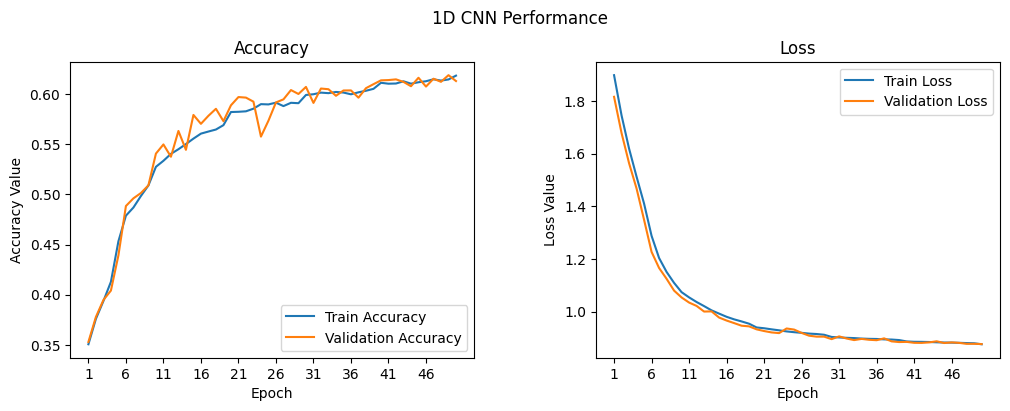

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [35]:
cnn_model.evaluate(X_test, y_test)

107/107 [==============================] - 1s 8ms/step - loss: 1.3901 - accuracy: 0.1626


[1.390070915222168, 0.1625659018754959]

In [36]:
print(y_test)

[0. 0. 0. ... 2. 2. 2.]


In [37]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_preds = np.around(cnn_model.predict(X_test))
print(y_test_preds)

 75/107 [====================>.........] - ETA: 0s

2023-02-15 12:01:48.535589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 0s 2ms/step
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [38]:
# y_test_preds = cnn_model.predict(X_test)
# print(np.around(y_test_preds[10:12]))
# print(y_test_preds[10:12])

In [39]:
y_test_preds.shape

(3414, 3)

In [40]:
y_preds = np.argmax(y_test_preds, axis=1)

In [41]:
print(y_preds)

[2 0 0 ... 2 0 0]


In [42]:
y_preds.shape

(3414,)

In [43]:
import sklearn.metrics as metrics

In [44]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.24      0.56      0.34      1138
         1.0       0.48      0.01      0.02      1138
         2.0       0.13      0.08      0.10      1138

    accuracy                           0.22      3414
   macro avg       0.28      0.22      0.15      3414
weighted avg       0.28      0.22      0.15      3414



In [45]:
# data_interp_base = interp.interp1d(np.arange(ecg_base_data.size),ecg_base_data)
# ecg_base_data = data_interp_base(np.linspace(0,ecg_base_data.size-1,838600))

In [46]:
# base_corr_max = []
# stress_corr_max = []
# amusement_corr_max = []

# ## Normalized Cross Correlation
#     norm_a = (test_base - np.mean(test_base)) / (np.std(test_base))
#     norm_b = (new_base - np.mean(new_base)) / (np.std(new_base))
#     base_corr = signal.correlate(norm_a, norm_b, 'full') / max(len(test_base), len(new_base))
#     base_corr_max.append(np.max(base_corr))
#     print('Base corr Max:', np.max(base_corr))
#     print('Max Array:', base_corr_max)
    
#     plt.plot(base_corr)
#     plt.show()
    
#     norm_c = (test_stress - np.mean(test_stress)) / (np.std(test_stress))
#     norm_d = (new_stress - np.mean(new_stress)) / (np.std(new_stress))
#     stress_corr = signal.correlate(norm_c, norm_d, 'full') / max(len(test_stress), len(new_stress))
#     stress_corr_max.append(np.max(stress_corr))
#     print('Stress corr Max:', np.max(stress_corr))
#     print('Max Array:', stress_corr_max)
    
#     plt.plot(stress_corr)
#     plt.show()
    
#     norm_x = (test_amusement - np.mean(test_amusement)) / (np.std(test_amusement))
#     norm_y = (new_amusement - np.mean(new_amusement)) / (np.std(new_amusement))
#     amusement_corr = signal.correlate(norm_x, norm_y, 'full') / max(len(test_amusement), len(new_amusement))
#     amusement_corr_max.append(np.max(amusement_corr))
#     print('Amusement corr Max:', np.max(amusement_corr))
#     print('Max Array:', amusement_corr_max)
    
#     plt.plot(amusement_corr)
#     plt.show()
    
# base_corr_avg = np.mean(base_corr_max)
# stress_corr_avg = np.mean(stress_corr_max)
# amusement_corr_avg = np.mean(amusement_corr_max)

# print('Avg base corr:', base_corr_avg)
# print('Avg stress corr:', stress_corr_avg)
# print('Avg amusement corr:', amusement_corr_avg)